<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/LOGO_INP_N7.png" alt="N7" height="80"/>

<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/logo-insa.png" alt="INSA" height="80"/>

# Méthodes de Runge-Kutta implicites - TP Projet

- Date : 2023-2024
- Durée approximative : inconnue

**Nom** : Rool

**Prénom** : Sara

## Rendu et consignes

Une fois le travail terminé, vous enverrez directement le fichier `.ipynb` par email à l'adresse : `olivier.cots@toulouse-inp.fr`.

- **Date limite du rendu : mercredi 15/11/2023 à 23h59.** Attention, à partir de 24h, 2 points est enlevé de la note finale toutes les 30 minutes.
- **Attention :** Le fichier doit être renommé de la façon suivante : `rk_implicites_NOM_Prenom.ipynb`. 4 points enlevés si le nom du fichier n'est pas respecté.
- **Documents autorisés :** vous pouvez utiliser votre polycopié et les TPs précédents.

## Introduction

Nous allons dans ce TP, implémenter quelques méthodes de Runge-Kutta **implicites** (voir **polycopié Section 8.2**) et étudier leur convergence. On considère un pas de temps $h$ uniforme. Une méthode à un pas implicite est convergente si pour toute solution $x(\cdot, t_0, x_0)$ d'un problème de Cauchy, la suite approximante ${(x_i)}_i$ donnée par la méthode à un pas implicite vérifie 
$$
    \max_{1 \le i \le N}\, \|{x(t_i, t_0, x_0) - x_i}\| \to 0 
    \quad\text{quand}\quad h \to 0.
$$

Si la convergence est d'ordre $p$ alors il existe une constante $C \ge 0$ telle que l'**erreur globale** $E$ vérifie

$$
    E := \max_{1 \le i \le N}\, \|{x(t_i, t_0, x_0) - x_i}\| \le C\, h^p.
$$

Faisons l'hypothèse que $E = M\, h^p$ pour un certain $M \ge 0$. En passant au logarithme, on obtient

$$
    \log(E) = \log(M) + p\, \log(h).
$$

Nous en déduisons que si on trace $\log(E)$ en fonction de $\log(h)$, on doit obtenir une droite de pente $p$. C'est ce que nous allons vérifier dans ce TP.

In [37]:
# activate local project
using Pkg
Pkg.activate(".")

# load packages
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using Polynomials

#
px = PlotMeasures.px;


  Activating project at `~/Downloads`
[ Info: Precompiling Polynomials [f27b6e38-b328-58d1-80ce-0feddd5e7a45]


In [314]:
# Fonctons auxiliaires 

function method_infos(method)

    if method == :euler_impl
        method_func = euler_impl
        method_name = "Euler_impl"
        methode_stages = 1
    elseif method == :trapèze 
        method_func = trapèze
        method_name = "Trapèze"
        methode_stages = 2
    elseif method == :gauss
        method_func = gauss
        method_name = "Gauss"
        methode_stages = 3
    elseif method == :euler_exp
        method_func = euler_exp
        method_name = "Euler_exp"
        methode_stages = 4
        
    else 
        error("Méthode d'intégration non reconnue")
    end

    return method_func, method_name, methode_stages

end

function convergence(method, f, x0, tspan, sol,  Nspan)

    # Récupération des informations sur la méthode
    method_func, method_name, methode_stages = method_infos(method)
    
    # Ecriture des choix de paramètres
    println("Méthode d'intégration : ", method_name)

    plts  = []           # Liste des graphiques

    for N ∈ Nspan

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N) # Appel de la méthode d'intégraton

        # Affichage de la solution approchée
        plt = plot(ts, xs, label=method_name, marker=:circle)

        # Affichage de la solution analytique
        plot!(plt, sol, label="Analytic")

        # Mise en forme du graphique
        plot!(plt, xlims=(tspan[1]-0.1, tspan[2]+0.1), ylims=(-0.2, 1.65), 
        title="h=$(round((tspan[2]-tspan[1])/N, digits=2))", titlefont = font(12,"Calibri"),
        xlabel="t", ylabel="x(t)", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

        # Ajout du graphique à la liste des graphiques
        push!(plts, plt)

    end

    return plts

end

xlims_ = (1e-4, 1e0)
ylims_ = (1e-13, 1e1)
xlims_nfe_ = (1e1, 1e4)
ylims_nfe_ = (1e-13, 1e1)

function ordre(method, f, x0, tspan, sol, hspan, nfespan; 
    xlims=xlims_, ylims=ylims_, xlims_nfe=xlims_nfe_, ylims_nfe=ylims_nfe_)

    plts = []           # Liste des graphiques

    #
    plt1 = plot(xaxis=:log, yaxis=:log); push!(plts, plt1)
    plt2 = plot(xaxis=:log, yaxis=:log); push!(plts, plt2)

    #
    plts = ordre(plts, method, f, x0, tspan, sol, hspan, nfespan, 
        xlims=xlims, ylims=ylims, xlims_nfe=xlims_nfe, ylims_nfe=ylims_nfe)

    # Mise en forme des graphiques
    plot!(plts[1], titlefont = font(12, "Calibri"), legend=:topleft,
    xlabel="h", ylabel="Error", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

    plot!(plts[2], titlefont = font(12, "Calibri"), legend=:topright,
    xlabel="Calls to f", ylabel="Error", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

    return plts
    
end

function ordre(plts_in, method, f, x0, tspan, sol, hspan, nfespan; 
    xlims=xlims_, ylims=ylims_, xlims_nfe=xlims_nfe_, ylims_nfe=ylims_nfe_)

    # Copie du graphique d'entrée
    plts = deepcopy(plts_in)

    # Récupération des informations sur la méthode
    method_func, method_name, methode_stages = method_infos(method)
    
    # Ecriture des choix de paramètres
    println("Méthode d'intégration : ", method_name)

    # Les différents nombre de pas de temps
    Nspan = round.(Int, (tspan[2]-tspan[1]) ./ hspan)

    # Calcul de l'erreur
    err = []

    for N ∈ Nspan

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N)

        # On calcule l'erreur en norme infinie
        push!(err, maximum(abs.(xs .- sol.(ts))))
        
    end

    # calcul par régression linéaire de la pente de la droite et de l'ordonnée à l'origine
    reg = fit(log10.(hspan), log10.(err), 1)
    K   = 10^reg[0]
    p   = reg[1]
    println("\nconstante du grand O : K = $(round(K, digits=5))")
    println("ordre de convergence : p = $(round(p, digits=5))")

    # Affichage de l'erreur en fonction du pas de temps: on enlève la constante K
    plot!(plts[1], hspan, err, xaxis=:log, yaxis=:log, label="$method_name", marker=:circle)

    # Affichage de la droite de régression
    #plot!(plt, hspan, hspan .^ p, label="$method_name Regression", linestyle=:dash)
    
    # Mise en forme du graphique
    plot!(plts[1], xlims=xlims, ylims=ylims)

    # Calcul de l'erreur en fonction du nombre d'appels à la fonction f
    err = []

    for Nfe ∈ Nfespan

        #
        N = round(Int, Nfe / methode_stages)

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N)

        # On calcule l'erreur en norme infinie
        push!(err, maximum(abs.(xs .- sol.(ts))))
        
    end

    # Affchage de l'erreur en fonction du nombre d'appels à la fonction f
    # Nfespan = methode_stages .* Nspan
    #plot!(plts[2], Nfespan, err, xaxis=:log, yaxis=:log, label="$method_name", marker=:circle)

    # Mise en forme du graphique
    plot!(plts[2], xlims=xlims_nfe, ylims=ylims_nfe)

    return plts
    
end;

hspan_   = 10 .^ range(-4, stop=0, length=20)
Nfespan_ = 10 .^ range(0, stop=4, length=20);

## L'exemple d'étude

On s'intéresse (pour les exercices 1, 2 et 3) au problème de Cauchy

$$
    \dot{x}(t) = (1-2t) x(t), \quad x(0) = x_0 = 1
$$

sur l'intervalle $[0, 3]$.

In [398]:
# Définition du problème de Cauchy
f(t, x) = (1-2t)x    # Second membre f(t, x)
x0 = 1.0             # Condition initiale
tspan = (0.0, 3.0);  # Intervalle de temps

In [399]:
# Solution analytique
function sol(t)
    return exp(t-t^2)
end;

In [400]:
# Estimation de la constante de Lipschitz de f sur [0, 3]
# Voir Théorème 8.2.2 pour l'utilité de cette estimation
function dfx(t)
    return 1-2t
end 
L = maximum(abs.(dfx.(range(0, stop=3, length=1000))))

5.0

## La méthode d'Euler implicite

La méthode d'Euler implicite est donnée par :

$$
\left\{
\begin{array}{l}
x_{n+1} = x_n + h f(t_n + h, x_{n+1}) \\
x_0 = x(t_0)
\end{array}
\right.
$$

### Exercice 1

1. Implémenter la méthode d'Euler implicite avec le point fixe (penser à voir le polycopié Section 8.2).
2. Pourquoi si $h \ge 0.2$, l'algorithme du point fixe peut s'arrêter au bout du nombre d'itérations max et donc ne pas converger pour la méthode d'Euler implicite ?
3. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
4. Tracer l'erreur globale de la méthode d'Euler implicite en fonction de $h$ et vérifier que l'erreur est bien en $O(h)$.

**Attention** : pour l'algorithme du point fixe, faites attention aux critères d'arrêts (il y en a 2) ! Voir votre polycopié Section 8.2. Vous fixerez la valeur de la tolérance à $10^{-6}$ et le nombre maximum d'itérations à $1000$.

In [401]:
# Implémentation de la méthode d'Euler implicite
function euler_impl(f, x0, tspan, N)
    tol_min = 1e-6
    nb_iter_max = 1000
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    
    G(y) = f(t+h, x+h*y)

    for i in 1:N
        y = f(t,x)
        tol = norm(y - G(y))
        nb_iter = 0
        
        while (nb_iter < nb_iter_max) & (tol > tol_min)
            y = G(y) 
            tol = norm(y - G(y))
            nb_iter = nb_iter + 1
        end
        
        x = x + h*f(t+h,x+h*y)
        t = t+h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

Méthode d'intégration : Euler_impl


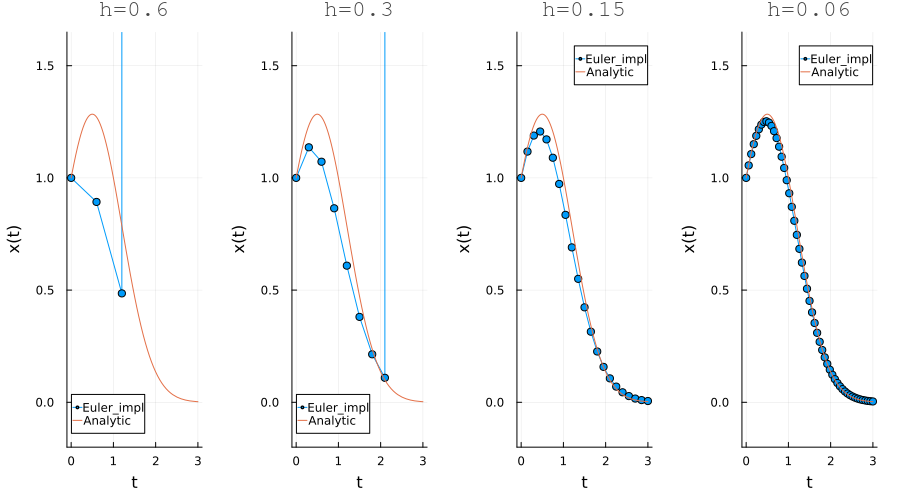

In [402]:
method = :euler_impl
Nspan  = [5, 10, 20, 50]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

Méthode d'intégration : Euler_impl

constante du grand O : K = 0.81871
ordre de convergence : p = 0.99526


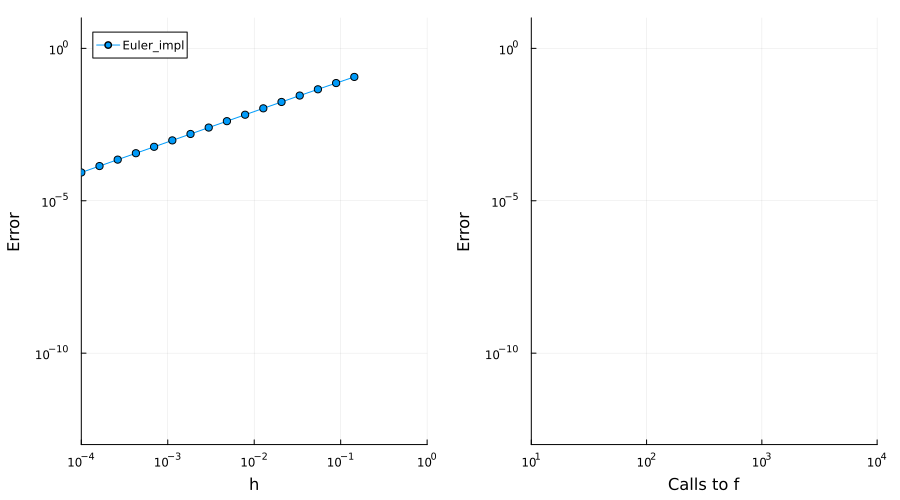

In [372]:
# Ordre de convergence de la méthode
method  = :euler_impl
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 0.2]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_euler_impl = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_euler_impl..., layout=(1, 2), size=(900, 500))


L'ordre de la méthode d'Euler implicite est 1.

D'après la formule du cours (théorème 8.2.2), il faut que h soit suffisament petit (dans notre cas h < 0.2) pour assurer une unique solution. Si on est au dessus de cette valeur on risque de dépasser le nombre d'itérations maximum et donc on ne trouvera pas la solution pour ce pas. Cette propriété est suffisante car on va le voir avec d'autres méthodes que même si on depasse cette valeur cela peut quand même fonctionner

## La méthode des trapèzes

La méthode des trapèzes est donnée par le tableau de Butcher :

$$
    \begin{array}{c | c c}
        0       & 0     & 0     \\[0.2em]
        1       & 1/2   & 1/2   \\[0.2em]
        \hline
                & 1/2   & 1/2   \\
    \end{array}
$$

### Exercice 2

1. Implémenter la méthode des trapèzes avec le point fixe.
2. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
3. Tracer l'erreur globale de la méthode des trapèzes. Quel est l'ordre de convergence de la méthode des trapèzes ?

In [403]:
# Implémentation de la méthode des trapèzes implicite
function trapèze(f, x0, tspan, N)
    tol_min = 1e-6
    nb_iter_max = 1000
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    
    G(y) = [y[1], f(t+h, x + (h/2).*(y[1] + y[2]))]
    
    for i in 1:N 
        y = [f(t,x),f(t,x)]

        tol = norm(y[2] .- G(y)[2])
        nb_iter = 0
        
        while (nb_iter < nb_iter_max) & (tol > tol_min)
            y = G(y) 
            tol = norm(y[2] .- G(y)[2])
            nb_iter = nb_iter + 1
        end
        
        x = x .+ (h/2).*(y[1] + f(t+h,x+(h/2).*(y[1].+y[2])))
        t = t+h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

Méthode d'intégration : Trapèze


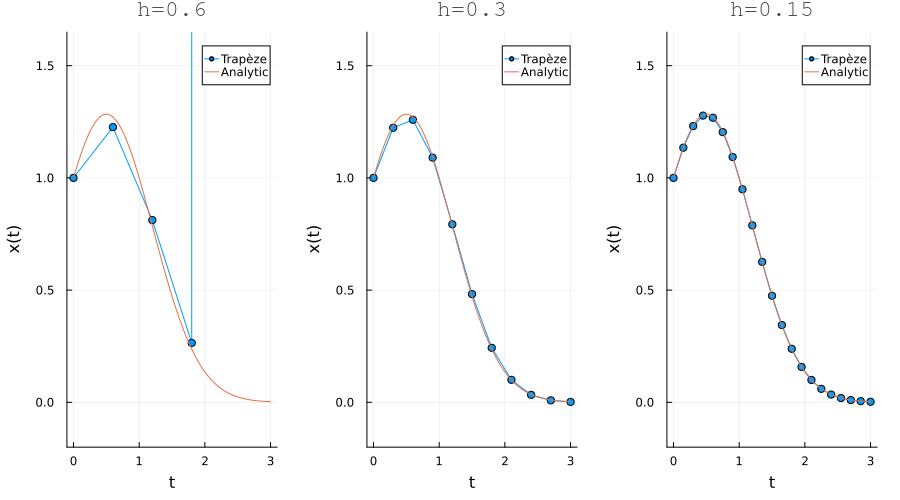

In [404]:
method = :trapèze
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

Méthode d'intégration : Trapèze

constante du grand O : K = 0.14454
ordre de convergence : p = 1.99744


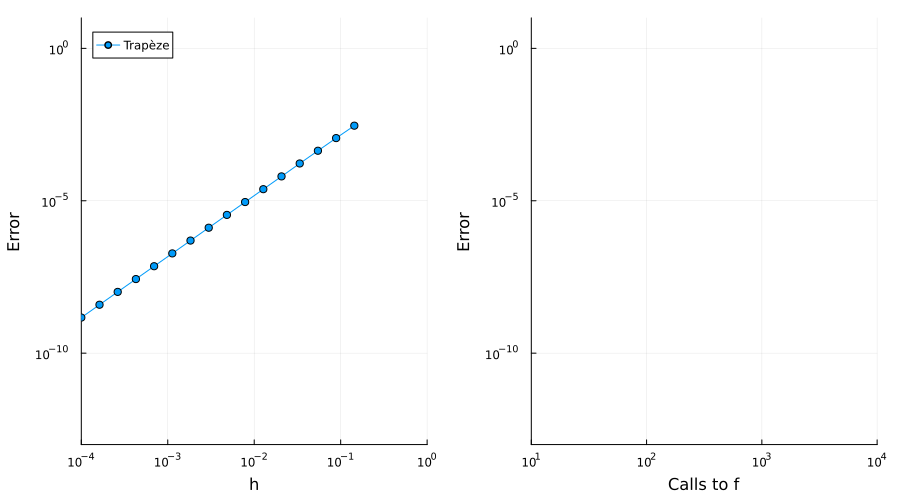

In [405]:
# Ordre de convergence de la méthode
method  = :trapèze
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 0.2]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_trapeze = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_trapeze..., layout=(1, 2), size=(900, 500))


L'ordre de la méthode des trapèzes implicite est 2.

## La méthode de Gauss à 2 étages

La méthode de Gauss à 2 étages est donnée par le tableau de Butcher :

$$
    \begin{array}{c | c c}
        1/2 - \sqrt{3}/6     & 1/4  & 1/4 - \sqrt{3}/6  \\[0.2em]
        1/2 + \sqrt{3}/6     & 1/4 + \sqrt{3}/6 & 1/4   \\[0.2em]
        \hline
        & 1/2 & 1/2 \\
    \end{array}
$$

### Exercice 3

1. Implémenter la méthode de Gauss à 2 étages avec le point fixe.
2. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
3. Tracer l'erreur globale de la méthode de Gauss à 2 étages. Quel est l'ordre de convergence de la méthode de Gauss à 2 étages ?

In [406]:
# Implémentation de la méthode d'Euler implicite
function gauss(f, x0, tspan, N)
    tol_min = 1e-6
    nb_iter_max = 1000
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    
    G(y) = [f(t+h*(0.5-sqrt(3)/6), x + h.*y[1].*0.25 + h.*y[2].*(0.25-sqrt(3)/6)),f(t+h*(0.5+sqrt(3)/6), x + h.*y[2].*0.25 + h.*y[1].*(0.25+sqrt(3)/6))]
    
    for i in 1:N 
        y = [f(t,x),f(t,x)]
        tol = norm(y - G(y))
        nb_iter = 0
        
        while (nb_iter < nb_iter_max) & (tol > tol_min)
            y = G(y) 
            tol = norm(y - G(y))
            nb_iter = nb_iter + 1
        end
        
        x = x + (h/2).*(f(t+h*(0.5-sqrt(3)/6), x + h.*y[1].*0.25 + h.*y[2].*(0.25-sqrt(3)/6)) + f(t+h*(0.5+sqrt(3)/6), x + h.*y[2].*0.25 + h.*y[1].*(0.25+sqrt(3)/6)))
        t = t+h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

Méthode d'intégration : Gauss


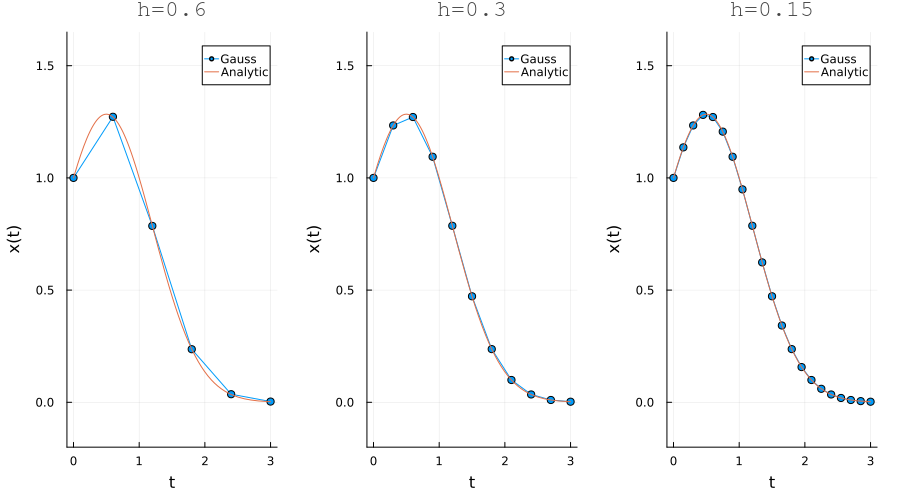

In [407]:
method = :gauss
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

Méthode d'intégration : Gauss

constante du grand O : K = 2.0e-5
ordre de convergence : p = 2.02672


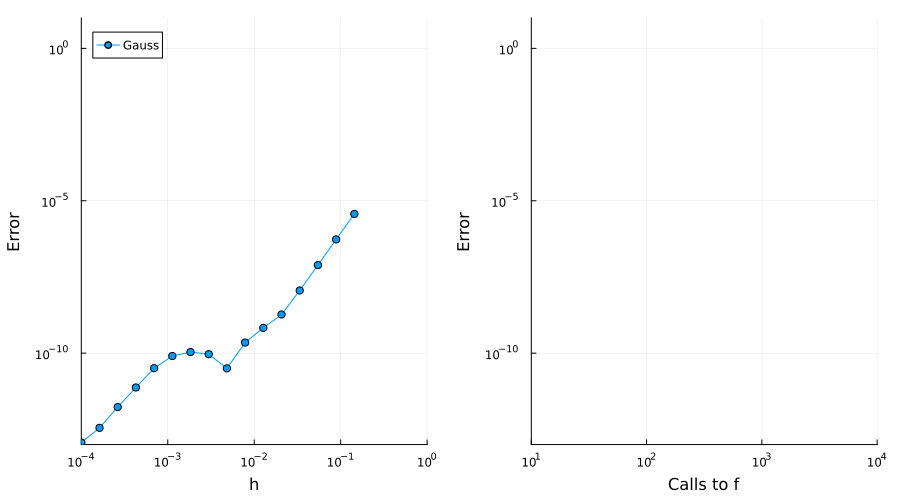

In [409]:
# Ordre de convergence de la méthode
method  = :gauss
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 0.2]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_gauss = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_gauss..., layout=(1, 2), size=(900, 500))


L'ordre de la méthode de Gauss implicite est 2.

## Un autre exemple

On considère à partir de maintenant l'équation différentielle en dimension 2 :

$$
    \dot{x}_1(t) = x_2(t), \quad \dot{x}_2(t) = - x_1(t).
$$

On peut montrer facilement que la norme de $x(t) = (x_1(t), x_2(t))$ est constante le long des solutions :

$$
    \frac{\mathrm{d}}{\mathrm{d} t} \|x(t)\|^2 = 2\, \left( x(t) \,|\, \dot{x}(t) \right) =  2 \left( x_1(t) x_2(t) - x_2(t) x_1(t) \right) = 0.
$$

### Exercice 4

On considère le problème de Cauchy associé de condition initiale $x_0 = (1, 0)$.

1. Afficher l'approximation de la solution sur $[0, 10]$ pour les méthodes :
- Euler explicite ;
- Euler implicite ;
- Trapèzes ;
- Gauss à 2 étages.
2. Commentaires.

**Attention :** vous ferez un affichage dans le plan $(x_1, x_2)$. Vous fixerez le nombre de pas à $N=100$.

In [410]:
# Implémentation de la méthode d'Euler explicite
function euler_exp(f, x0, tspan, N)
    t0, tf = tspan
    h = (tf - t0) / N
    t = t0
    x = x0
    ts = [t0]
    xs = [x0]
    for i in 1:N
        x = x + h*f(t,x)
        t = t+h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end;

In [411]:
# Définition du problème de Cauchy
f2(t, X) = [X[2], -X[1]]   # Second membre f(t, x)
X0 = [1.0,0.0]           # Condition initiale
tspan2 = (0.0, 10.0);  # Intervalle de temps

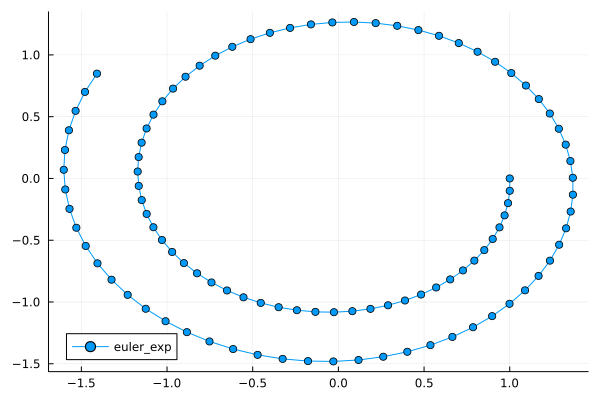

In [412]:
ts, xs = euler_exp(f2, X0, tspan2, 100)
plot([X[1] for X in xs], [X[2] for X in xs], label=euler_exp, marker=:circle)

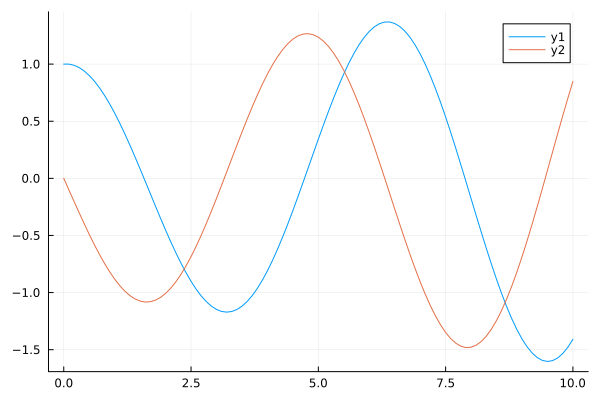

In [413]:
plot(ts, [[X[1] for X in xs],[X[2] for X in xs]])

On remarque l'effet spirale les cosinus et sinus divergent

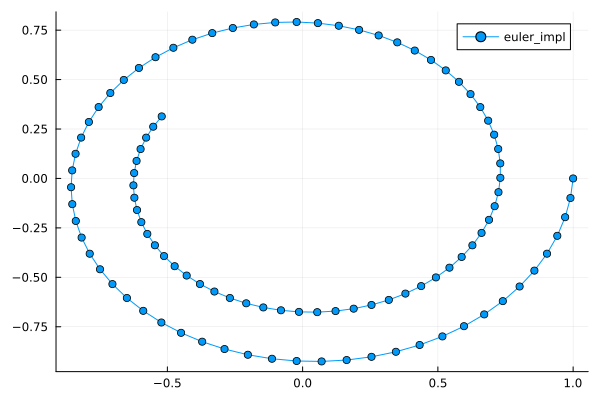

In [414]:
ts, xs = euler_impl(f2, X0, tspan2, 100)
plot([X[1] for X in xs], [X[2] for X in xs], label=euler_impl, marker=:circle)

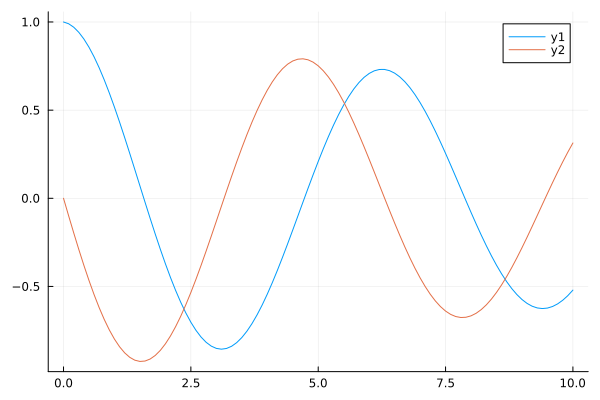

In [415]:
plot(ts, [[X[1] for X in xs],[X[2] for X in xs]])

Au contraire, on remarque l'effet amortissant, d'où la spirale interne.

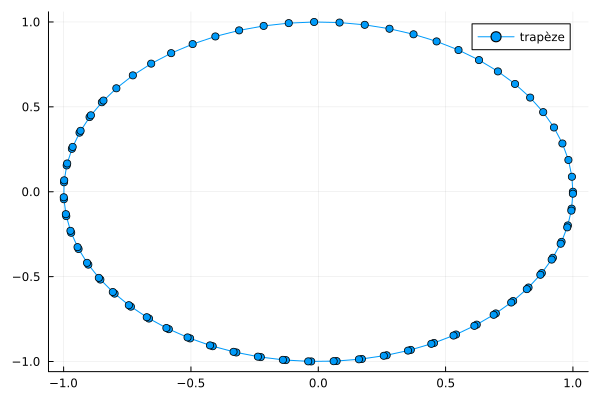

In [416]:
ts, xs = trapèze(f2, X0, tspan2, 100)
plot([X[1] for X in xs], [X[2] for X in xs], label=trapèze, marker=:circle)

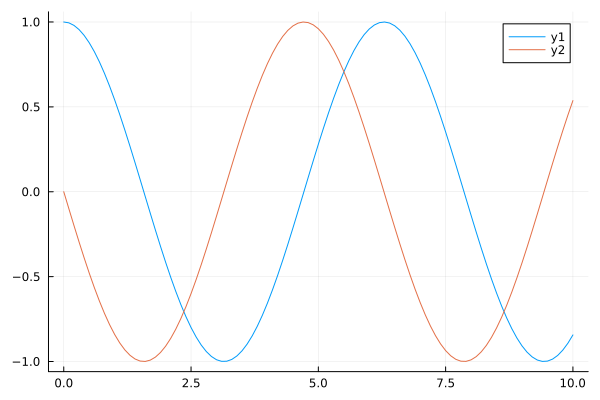

In [417]:
plot(ts, [[X[1] for X in xs],[X[2] for X in xs]])

Il n'y a pas d'effet d'amplification ou d'amortissement.

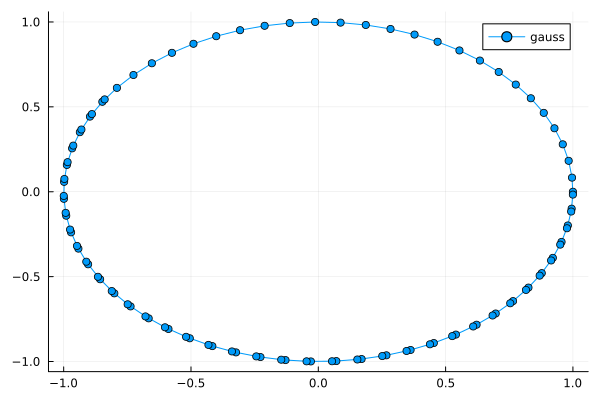

In [418]:
ts, xs = gauss(f2, X0, tspan2, 100)
plot([X[1] for X in xs], [X[2] for X in xs], label=gauss, marker=:circle)

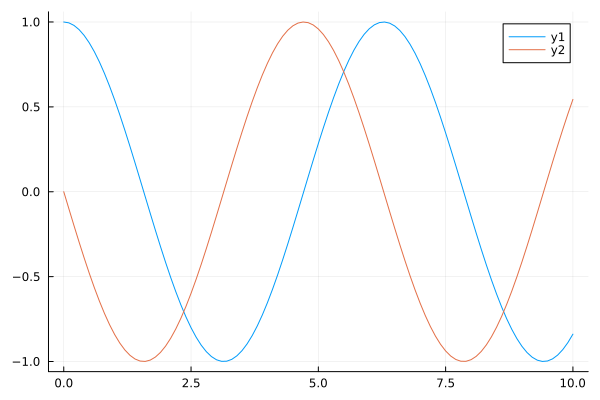

In [419]:
plot(ts, [[X[1] for X in xs],[X[2] for X in xs]])

Il n'y a pas d'effet d'amplification ou d'amortissement ici aussi.

Pour la méthode d'Euler explicite, on part de notre solution intiale et on "diverge" car on prends en compte seulement le x précédent. On va rajouter un pas à notre valeur précédente ce qui a pour effet de la faire croitre au fur à mesure même si on conserve la même tendance. Pour les méthodes d'Euler implicite, c'est l'inverse. On prend en compte notre x actuel donc on va avoir un effet de spirale intérieure.

On remarque une différence entre les méthodes d'ordre 2 (trapèze et gauss) et celle d'ordre 1. Les méthodes d'ordres sont moins sensibles au h donc au N. En effet, le h actuel (0.1) est trop grand pour les ordres 1. Il faudrait prendre plus de point N pour avoir une meilleure approximation.
Par exemple, pour N = 1000 et la méthode d'Euler implicite on obtient :

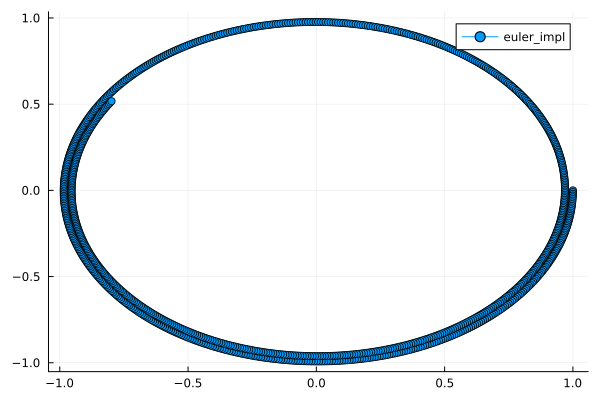

In [420]:
ts, xs = euler_impl(f2, X0, tspan2, 1000)
plot([X[1] for X in xs], [X[2] for X in xs], label=euler_impl, marker=:circle)

Cela se rapproche beaucoup plus d'un cercle, et nous n'avons plus cet effet spirale.